In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [ ]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/CTI/cti/Inggris/train.txt', names=['Text', 'Category'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/CTI/cti/Inggris/val.txt', names=['Text', 'Category'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/CTI/cti/Inggris/test.txt', names=['Text', 'Category'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Category']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Category']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Category']

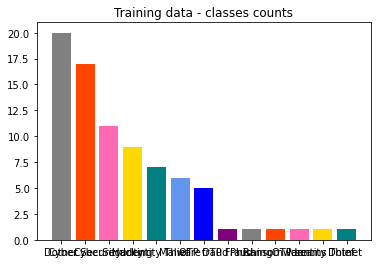

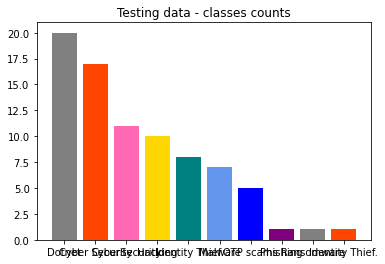

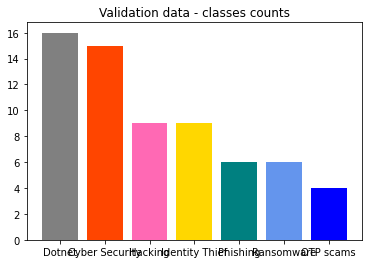

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue','blue','purple'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()



In [ ]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 353


In [ ]:
# Read GloVE embeddings

path_to_glove_file = '/content/drive/MyDrive/CTI/cti/Indonesia/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 336 words (16 misses)


In [ ]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(13, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 200)          70600     
                                                                 
 bidirectional_3 (Bidirectio  (None, 256, 512)         935936    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 256, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 13)                3341      
                                                      

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
1/1 [==============================] - 19s 19s/step - loss: 0.6870 - accuracy: 0.7901 - val_loss: 0.5879 - val_accuracy: 0.8272
Epoch 2/10
1/1 [==============================] - 19s 19s/step - loss: 0.5306 - accuracy: 0.8642 - val_loss: 0.5171 - val_accuracy: 0.8519


In [ ]:
model.evaluate(X_val, y_val, verbose=1)

3/3 [==============================] - 5s 1s/step - loss: 0.5442 - accuracy: 0.8462


[0.5441538691520691, 0.8461538553237915]

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            "There was a cyber crime that stole WA user data",
             "OTP code that is shared with other people allows the perpetrator to collect user data",
             "Fake Google Translate apps can capture user data",
             "Bjorka hacks careprotect app",
             "Indonesia Lacks Cyber Security Experts"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

There was a cyber crime that stole WA user data
1/1 [==============================] - 1s 616ms/step
Phishing : 0.8587570786476135


OTP code that is shared with other people allows the perpetrator to collect user data
1/1 [==============================] - 1s 626ms/step
OTP scams : 0.8048200011253357


Fake Google Translate apps can capture user data
1/1 [==============================] - 1s 628ms/step
Dotnet : 0.7364051938056946


Bjorka hacks careprotect app
1/1 [==============================] - 1s 632ms/step
Phishing : 0.23644918203353882


Indonesia Lacks Cyber Security Experts
1/1 [==============================] - 1s 636ms/step
Cyber Security : 0.9369083642959595




In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Category Recognition.h5')